In [1]:
import numpy as np

class StochasticMDP:
    def __init__(self):
        self.end           = False
        self.current_state = 2
        self.num_actions   = 2
        self.num_states    = 6
        self.p_right       = 0.5

    def reset(self):
        self.end = False
        self.current_state = 2
        state = np.zeros(self.num_states)
        state[self.current_state - 1] = 1.
        return state

    def step(self, action):
        if self.current_state != 1:
            if action == 1:
                if random.random() < self.p_right and self.current_state < self.num_states:
                    self.current_state += 1
                else:
                    self.current_state -= 1
                    
            if action == 0:
                self.current_state -= 1
                
            if self.current_state == self.num_states:
                self.end = True
        
        state = np.zeros(self.num_states)
        state[self.current_state - 1] = 1.
        
        if self.current_state == 1:
            if self.end:
                return state, 1.00, True, {}
            else:
                return state, 1.00/100.00, True, {}
        else:
            return state, 0.0, False, {}

In [2]:
from collections import deque

class ReplayBuffer(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer   = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        state      = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.concatenate(state), action, reward, np.concatenate(next_state), done
    
    def __len__(self):
        return len(self.buffer)

In [3]:
import random
import torch.nn as nn

class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(Net, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(num_inputs, 256),
            nn.ReLU(),
            nn.Linear(256, num_outputs)
        )
    
    def forward(self, x):
        return self.layers(x)
    
    def act(self, state, epsilon):
        if random.random() > epsilon:
            state  = torch.FloatTensor(state).unsqueeze(0)
            action = self.forward(state).max(1)[1]
            return action.data[0]
        else:
            return random.randrange(num_actions)

In [4]:
env = StochasticMDP()

In [5]:
num_goals    = env.num_states
num_actions  = env.num_actions

import torch

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model        = Net(2*num_goals, num_actions).to(device)
target_model = Net(2*num_goals, num_actions).to(device)

meta_model        = Net(num_goals, num_goals).to(device)
target_meta_model = Net(num_goals, num_goals).to(device)


import torch.optim as optim

optimizer      = optim.Adam(model.parameters())
meta_optimizer = optim.Adam(meta_model.parameters())

replay_buffer      = ReplayBuffer(10000)
meta_replay_buffer = ReplayBuffer(10000)

In [6]:
def to_onehot(x):
    oh = np.zeros(6)
    oh[x - 1] = 1.
    return oh

In [7]:
def update(model, optimizer, replay_buffer, batch_size):
    if batch_size > len(replay_buffer):
        return
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)
    
    state      = torch.FloatTensor(state)
    next_state = torch.FloatTensor(next_state)
    action     = torch.LongTensor(action)
    reward     = torch.FloatTensor(reward)
    done       = torch.FloatTensor(done)
    
    q_value = model(state)
    q_value = q_value.gather(1, action.unsqueeze(1)).squeeze(1)
    
    next_q_value     = model(next_state).max(1)[0]
    expected_q_value = reward + 0.99 * next_q_value * (1 - done)
   
    loss = (q_value - expected_q_value.data).pow(2).mean()
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [8]:
import math

epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 500

epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) \
                                                                        * math.exp(-1. * frame_idx / epsilon_decay)

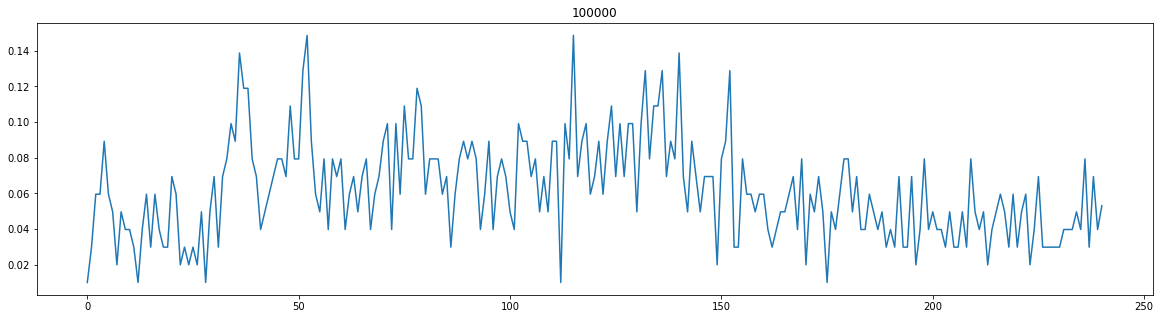

In [9]:
from IPython.display import clear_output
import matplotlib.pyplot as plt

num_frames = 100000
frame_idx  = 1

state = env.reset()
done = False
all_rewards = []
episode_reward = 0

while frame_idx < num_frames:
    goal = meta_model.act(state, epsilon_by_frame(frame_idx))
    onehot_goal  = to_onehot(goal)
    
    meta_state = state
    extrinsic_reward = 0
    
    while not done and goal != np.argmax(state):
        goal_state  = np.concatenate([state, onehot_goal])
        action = model.act(goal_state, epsilon_by_frame(frame_idx))
        next_state, reward, done, _ = env.step(action)

        episode_reward   += reward
        extrinsic_reward += reward
        intrinsic_reward = 1.0 if goal == np.argmax(next_state) else 0.0

        replay_buffer.push(goal_state, action, intrinsic_reward, np.concatenate([next_state, onehot_goal]), done)
        state = next_state
        
        update(model, optimizer, replay_buffer, 32)
        update(meta_model, meta_optimizer, meta_replay_buffer, 32)
        frame_idx += 1
        
        if frame_idx % 1000 == 0:
            
            
            clear_output(True)
            n = 100 #mean reward of last 100 episodes
            plt.figure(figsize=(20,5))
            plt.title(frame_idx)
            plt.plot([np.mean(all_rewards[i:i + n]) for i in range(0, len(all_rewards), n)])
            plt.show()

    meta_replay_buffer.push(meta_state, goal, extrinsic_reward, state, done)
        
    if done:
        state = env.reset()
        done  = False
        all_rewards.append(episode_reward)
        episode_reward = 0